In [1]:
## import os
import sys
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.table import Table
from copy import deepcopy

In [2]:
cat = Table.read('jvds_stelkin_cat_v012_mge_v310820_private.fits', hdu=1)
df = cat.to_pandas()

headers_in = ["RE_CIRC_KPC", "MU_AT_RE", "LMSTAR", "SIGMA_RE", "GMINUSI", "MTYPE", "N_SERSIC"]

RE_CIRC_KPC:      FLOAT - Effective Circularised radius in KiloParsec from MGE (F. D'Eugenio in Prep.). \
MU_AT_RE:         FLOAT - Mean surface density at one Re from Bryant et al. 2015 \
LMSTAR:           FLOAT - Log_10 Stellar mass derived from g-i colour from Bryant et al. 2015 and Owers et al. 2017. \ \

GMINUSI:          FLOAT - g-i colour from from Bryant et al. 2015 and Owers et al. 2017. \
MTYPE:            FLOAT - SAMI visual morphological type from Cortese et al. 2016 \
N_SERSIC:         FLOAT - Sersic index from the GAMA best-fit 2D Sersic profile in the r-band Lee et al. 2012 (Concentration)

In [3]:
# Load in our mass radius, mtype and ID data
radius = cat.field('RE_CIRC_KPC')
density = cat.field("MU_AT_RE")
log_mass = cat.field('LMSTAR')
sigma = cat.field("SIGMA_RE")

colour = cat.field("GMINUSI")
mtype = cat.field("MTYPE")
sindex = cat.field("N_SERSIC")

In [4]:
# This is done in order to make the visualisation of the morphological types easier through a colorbar function 

mtype_old = deepcopy(mtype)
for i in range(len(mtype_old)):
    if mtype_old[i] == -9:
        mtype[i] = 6

---

## Lets explore the data and remove any outliers

In [5]:
data_vectors = [radius, density, log_mass, colour, mtype, sindex, sigma]
data_names = ["radius", "density", "log_mass", "colour", "mtype", "sindex", "sigma"]

/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


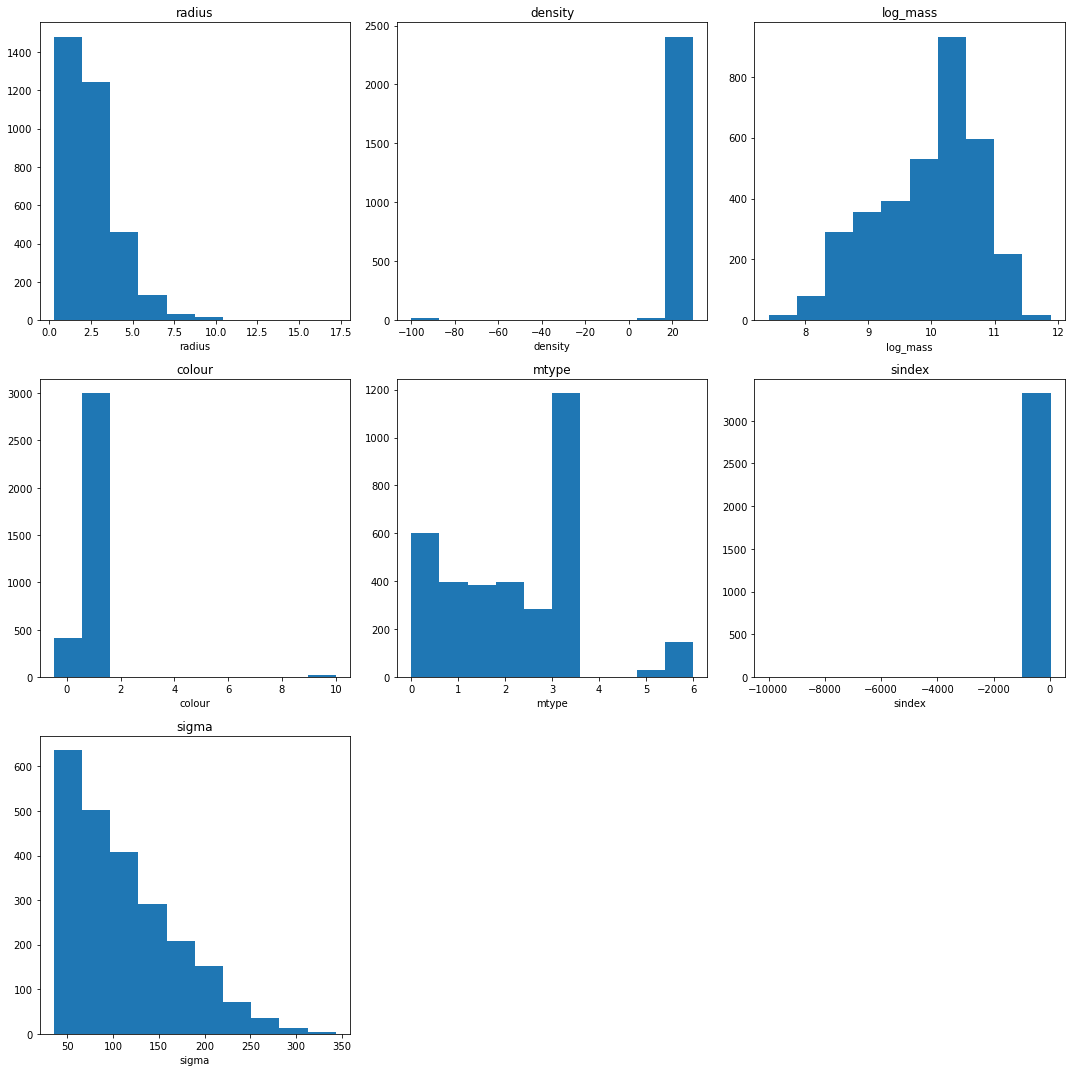

In [6]:
n = len(data_vectors)

plt.figure(figsize=(15, 15))

for i in range(n):
    plt.subplot(3, n//2, i+1)
    plt.hist(data_vectors[i])
    plt.title("{}".format(data_names[i]))
    plt.xlabel(data_names[i])
        
plt.tight_layout()

In [7]:
# Get rid of the crazy outliers, (some crazy sindex one, and the -9 and 5 entires of morphological type)
m1 = sindex > 0
m2 = mtype < 5
m3 = radius <= 10
m4 = (density <= 27.5)*(density >= 18)
m5 = (colour >= 0)*(colour <= 1.5)
m6 = sindex <= 8
mtrain = mtype <= 1.5

/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(super(), op)(other)
/usr/local/anaconda3/envs/comp/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(super(), op)(other)


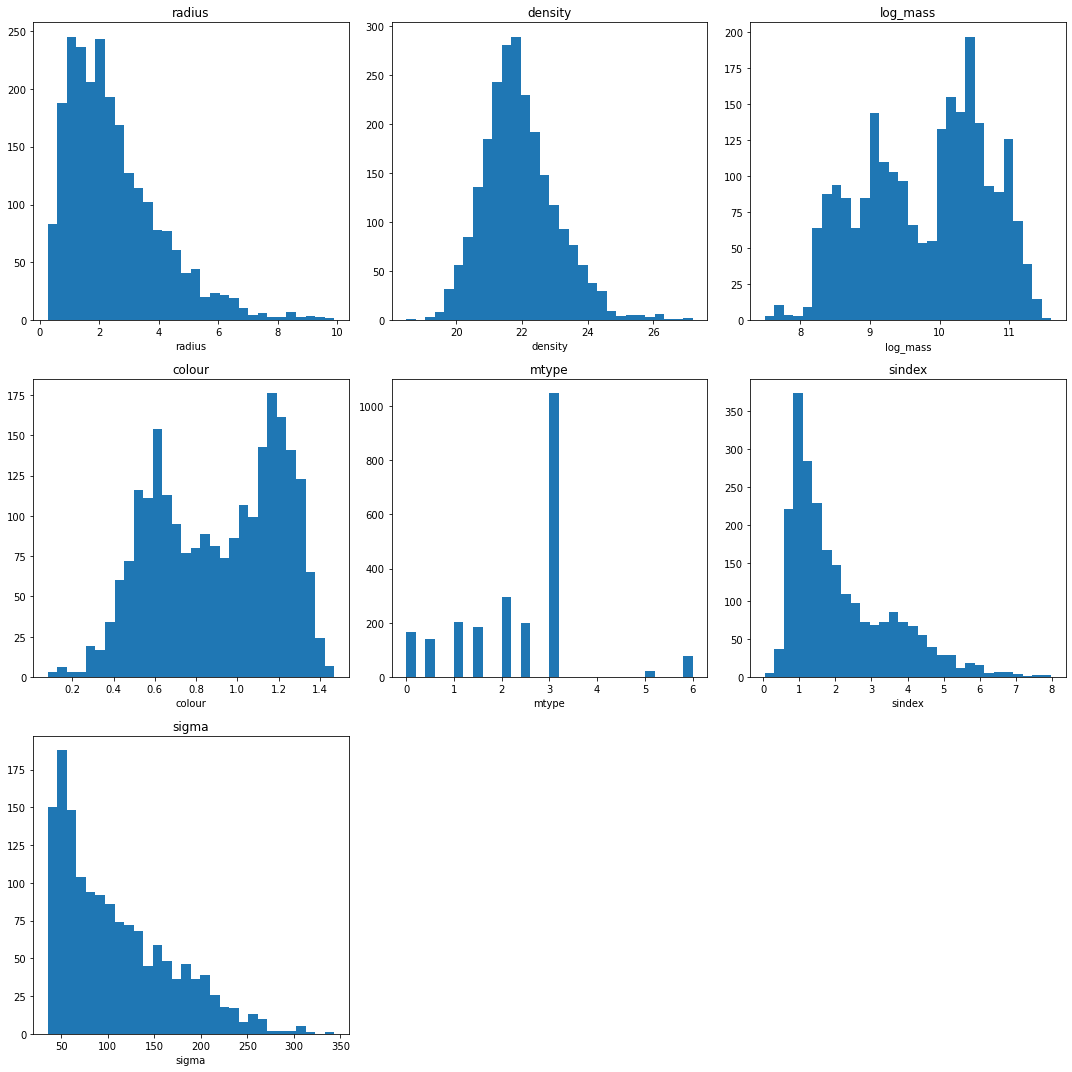

In [8]:
mask_train = m3*m4*mtrain
mask_all = m1*m3*m4*m5*m6

n = len(data_vectors)
plt.figure(figsize=(15, 15))

for i in range(n):
    plt.subplot(3, n//2, i+1)
    plt.hist(data_vectors[i][mask_all], bins=30)
    plt.title("{}".format(data_names[i]))
    plt.xlabel(data_names[i])
        
plt.tight_layout()

---
# Linear Regression

In [9]:
def FPR_euclid(plane_params, data, sum_out=False):
    """
    Sum of squared error with euclidian distance from plane
    plane params should be coefficient1, coefficient2, intercept
    data should be [x, y, z]
    """
    numer = np.abs(plane_params[0]*data[0] + plane_params[1]*data[1] + plane_params[2] - data[2])
    denom = np.sqrt(plane_params[0]**2 + plane_params[1]**2 + 1)
    if sum_out:
        return np.sum((numer/denom)**2)
    else:
        return (numer/denom)**2

def FPR_manhat(plane_params, data, sum_out=False):
    """
    Sum of squared error with manhatan distance from plane
    plane params should be coefficient1, coefficient2, intercept
    data should be [x, y, z]
    """
    diff = np.abs(plane_params[0]*data[0] + plane_params[1]*data[1] + plane_params[2] - data[2])
    if sum_out:
        return np.sum(diff**2)
    else:
        return diff**2

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [11]:
# Only fit plane on low mtype
nan_mask = mask_train*np.logical_not(np.isnan(sigma))
xvals = sigma[nan_mask]
yvals = density[nan_mask]
zvals = radius[nan_mask]
col_val = colour[nan_mask]

xvals -= np.median(xvals)
yvals -= np.median(yvals)
zvals -= np.median(zvals)
data = np.array([xvals, yvals, zvals])
print(data.shape)

##############
# All mtypes #
##############
nan_mask_all = mask_all*np.logical_not(np.isnan(sigma))
xvals_all = sigma[nan_mask_all]
yvals_all = density[nan_mask_all]
zvals_all = radius[nan_mask_all]
col_val_all = colour[nan_mask_all]

xvals_all -= np.median(xvals_all)
yvals_all -= np.median(yvals_all)
zvals_all -= np.median(zvals_all)
data_all = np.array([xvals_all, yvals_all, zvals_all])
print(data_all.shape)

(3, 593)
(3, 1490)


In [12]:
lin = LinearRegression(normalize=True).fit(np.array(data[:2]).T, np.array(data[2]))
plane_params = [lin.coef_[0], lin.coef_[1], lin.intercept_]
print(FPR_euclid(plane_params, data, sum_out=True))
print(FPR_manhat(plane_params, data, sum_out=True))

217.01663
461.0161


In [13]:
xs = np.linspace(np.min(data[0]), np.max(data[0]))
ys = np.linspace(np.min(data[1]), np.max(data[1]))  
X, Y = np.meshgrid(xs, ys)
Z = lin.coef_[0]*X + lin.coef_[1]*Y + lin.intercept_

---

## Let see how this plane fit has performed

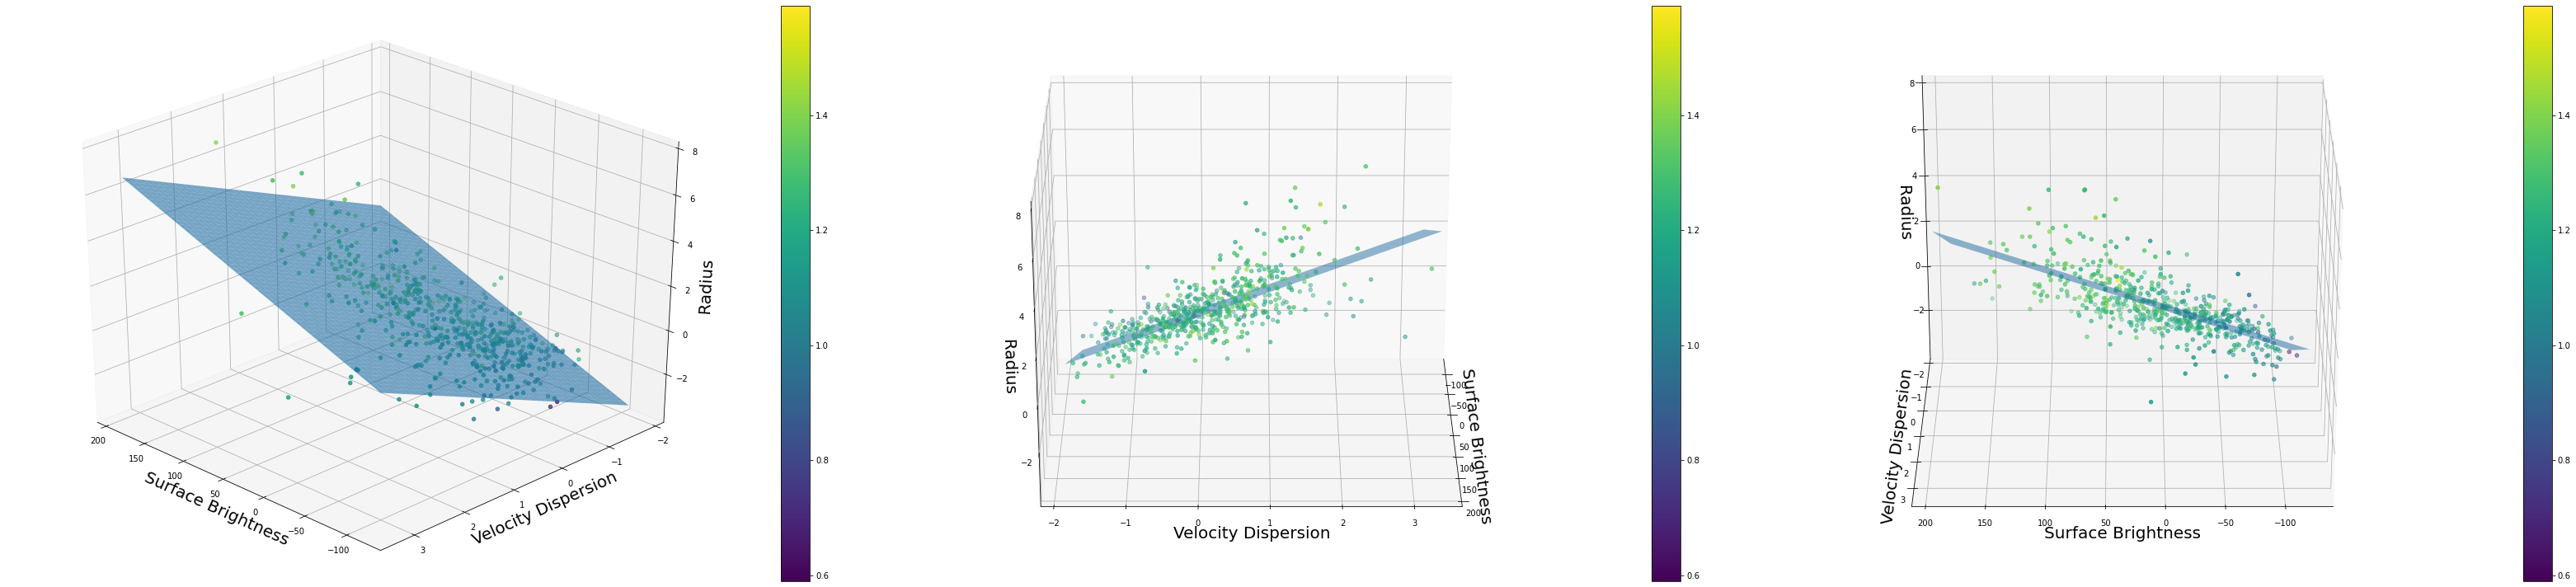

In [14]:
fig = plt.figure(figsize=(45,10))

ax = fig.add_subplot(131, projection='3d')
c = ax.scatter(data[0], data[1], data[2], c=col_val)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(30, 135)
plt.colorbar(c)
ax.set_xlabel("Surface Brightness", fontsize=20)
ax.set_ylabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

ax = fig.add_subplot(132, projection='3d')
c = ax.scatter(data[0], data[1], data[2], c=col_val)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(25, 0)
plt.colorbar(c)
ax.set_xlabel("Surface Brightness", fontsize=20)
ax.set_ylabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

ax = fig.add_subplot(133, projection='3d')
c = ax.scatter(data[0], data[1], data[2], c=col_val)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(25, 90)
plt.colorbar(c)
ax.set_xlabel("Surface Brightness", fontsize=20)
ax.set_ylabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

plt.tight_layout()

---

## Lets now look at the plane fit with all the parameters 

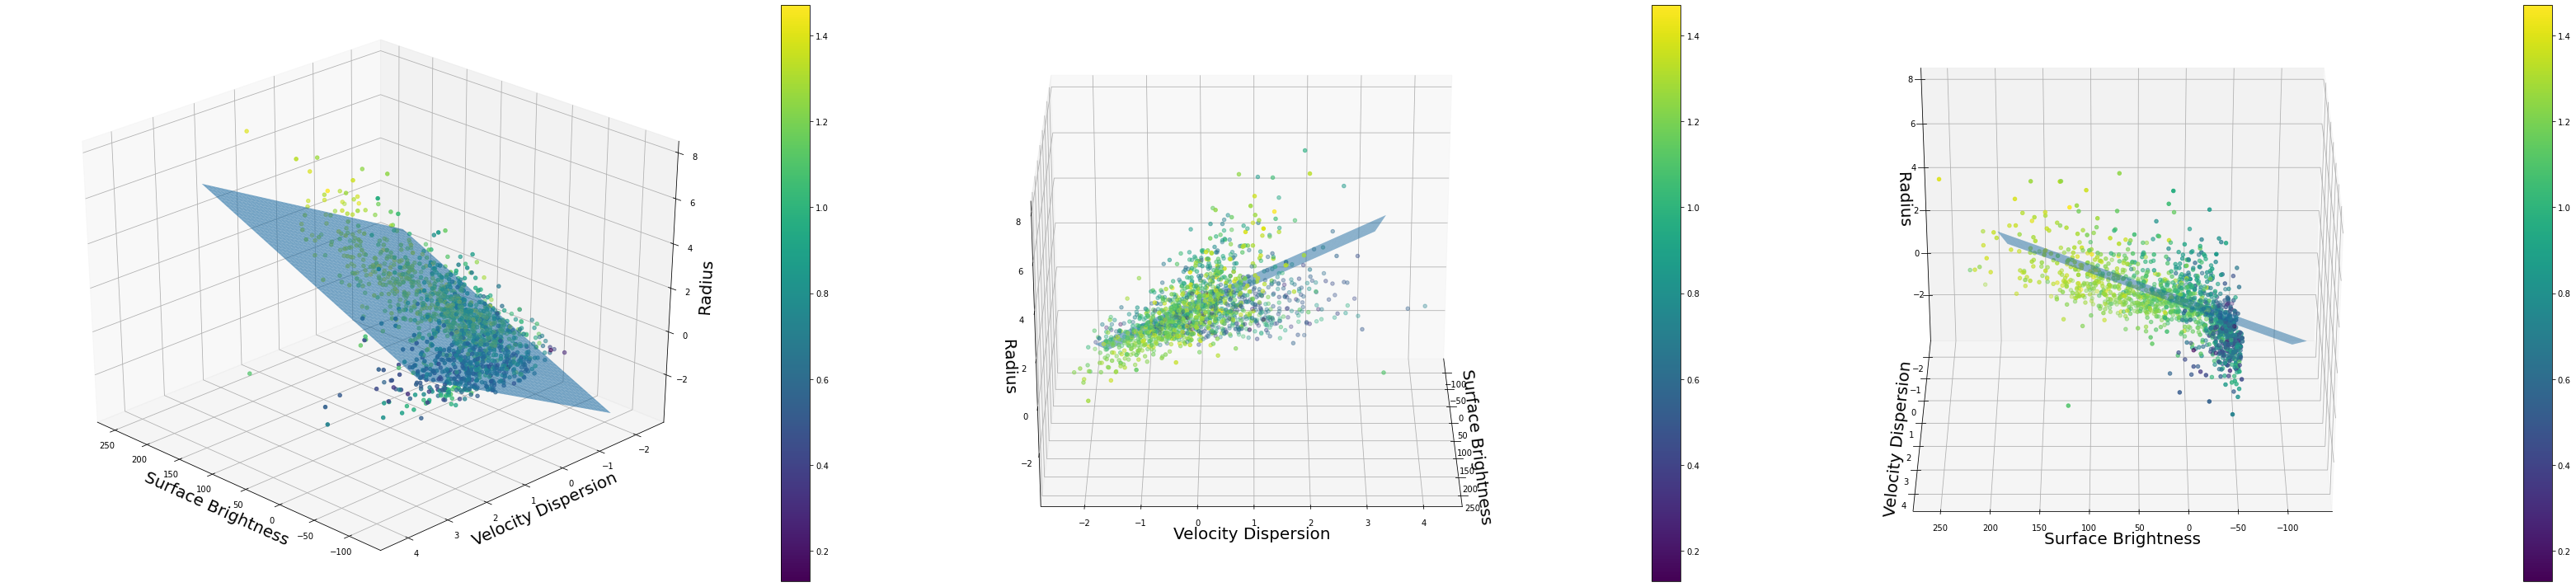

In [15]:
fig = plt.figure(figsize=(45,10))

ax = fig.add_subplot(131, projection='3d')
c = ax.scatter(data_all[0], data_all[1], data_all[2], c=col_val_all)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(30, 135)
plt.colorbar(c)
ax.set_xlabel("Surface Brightness", fontsize=20)
ax.set_ylabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

ax = fig.add_subplot(132, projection='3d')
c = ax.scatter(data_all[0], data_all[1], data_all[2], c=col_val_all)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(25, 0)
plt.colorbar(c)
ax.set_xlabel("Surface Brightness", fontsize=20)
ax.set_ylabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

ax = fig.add_subplot(133, projection='3d')
c = ax.scatter(data_all[0], data_all[1], data_all[2], c=col_val_all)
ax.plot_surface(X, Y, Z, alpha=0.6)
ax.view_init(30, 90)
plt.colorbar(c)
ax.set_xlabel("Surface Brightness", fontsize=20)
ax.set_ylabel("Velocity Dispersion", fontsize=20)
ax.set_zlabel("Radius", fontsize=20)

plt.tight_layout()

In [16]:
print(FPR_euclid(plane_params, data_all, sum_out=True))
print(FPR_manhat(plane_params, data_all, sum_out=True))

957.15265
2033.3132


In [17]:
distances_train = FPR_manhat(plane_params, data)
distances_all = FPR_manhat(plane_params, data_all)

---

## Lets plot how the distance from the plane fit varies as a fucntion of each parameter (plotting only those used to find the relation)

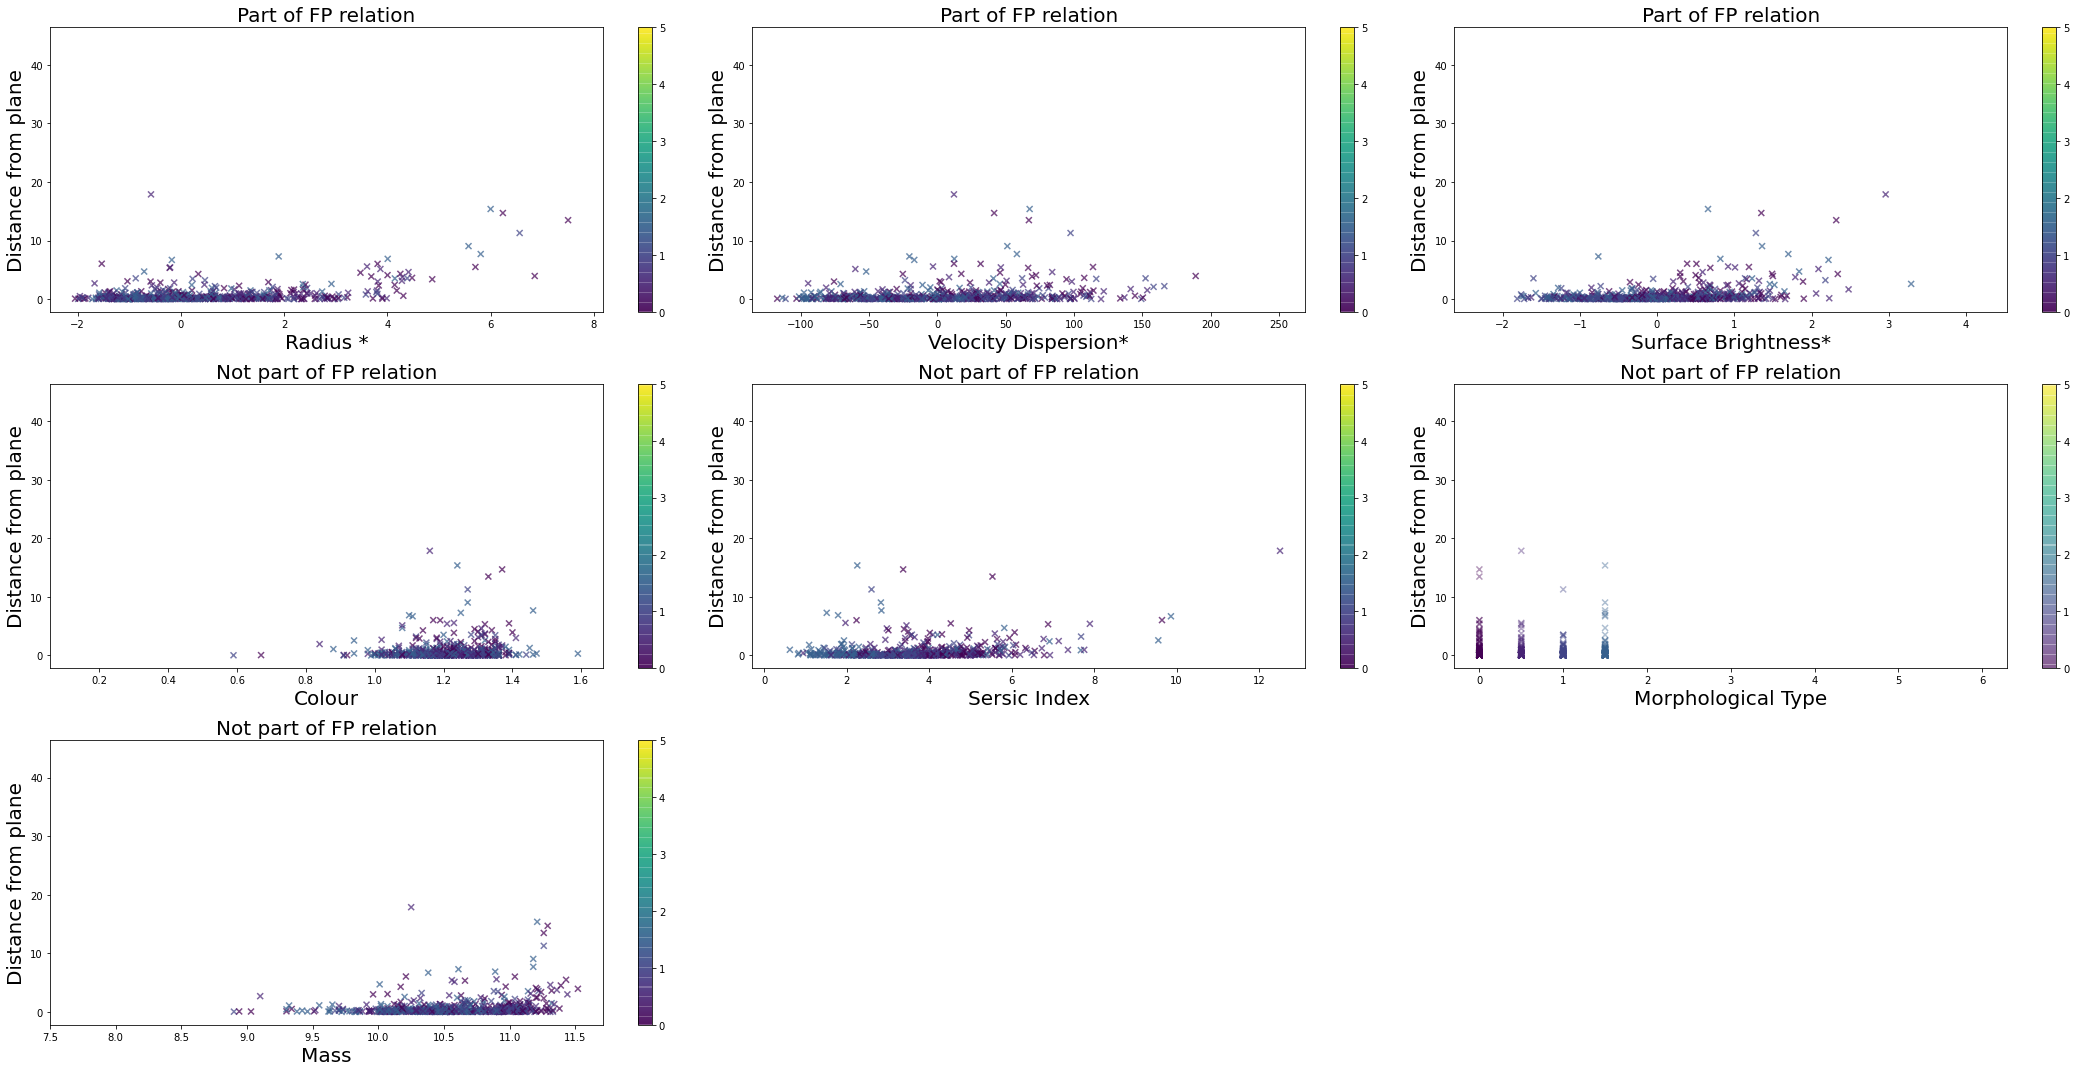

In [18]:
plt.figure(figsize=(30, 15))
c = mtype[nan_mask_all]
c_train = mtype[nan_mask]

plt.subplot(3, 3, 1)
plt.scatter(data_all[2], distances_all, c=c, alpha=0,)
plt.scatter(data[2], distances_train, c=c_train, marker='x', alpha=0.7)
plt.xlabel('Radius *', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)

plt.subplot(3, 3, 2)
plt.scatter(data_all[0], distances_all, c=c, alpha=0,)
plt.scatter(data[0], distances_train, c=c_train, marker='x', alpha=0.7)
plt.xlabel('Velocity Dispersion*', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)

plt.subplot(3, 3, 3)
plt.scatter(data_all[1], distances_all, c=c, alpha=0,)
plt.scatter(data[1], distances_train, c=c_train, marker='x', alpha=0.7)
plt.xlabel('Surface Brightness*', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)

plt.subplot(3, 3, 4)
plt.scatter(colour[nan_mask_all], distances_all, c=c, alpha=0,)
plt.scatter(colour[nan_mask], distances_train, c=c_train, marker='x', alpha=0.7)
plt.xlabel('Colour', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Not part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)

plt.subplot(3, 3, 5)
plt.scatter(sindex[nan_mask_all], distances_all, c=c, alpha=0,)
plt.scatter(sindex[nan_mask], distances_train, c=c_train, marker='x', alpha=0.7)
plt.xlabel('Sersic Index', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Not part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)

plt.subplot(3, 3, 6)
plt.scatter(mtype[nan_mask_all], distances_all, c=c, alpha=0,)
plt.scatter(mtype[nan_mask], distances_train, c=c_train, marker='x', alpha=0.4)
plt.xlabel('Morphological Type', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Not part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)

plt.subplot(3, 3, 7)
plt.scatter(log_mass[nan_mask_all], distances_all, c=c, alpha=0,)
plt.scatter(log_mass[nan_mask], distances_train, c=c_train, marker='x', alpha=0.7)
plt.xlabel('Mass', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Not part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)
 
plt.tight_layout()
plt.show()

---

## Lets plot how the distance from the plane fit varies as a fucntion of each parameter

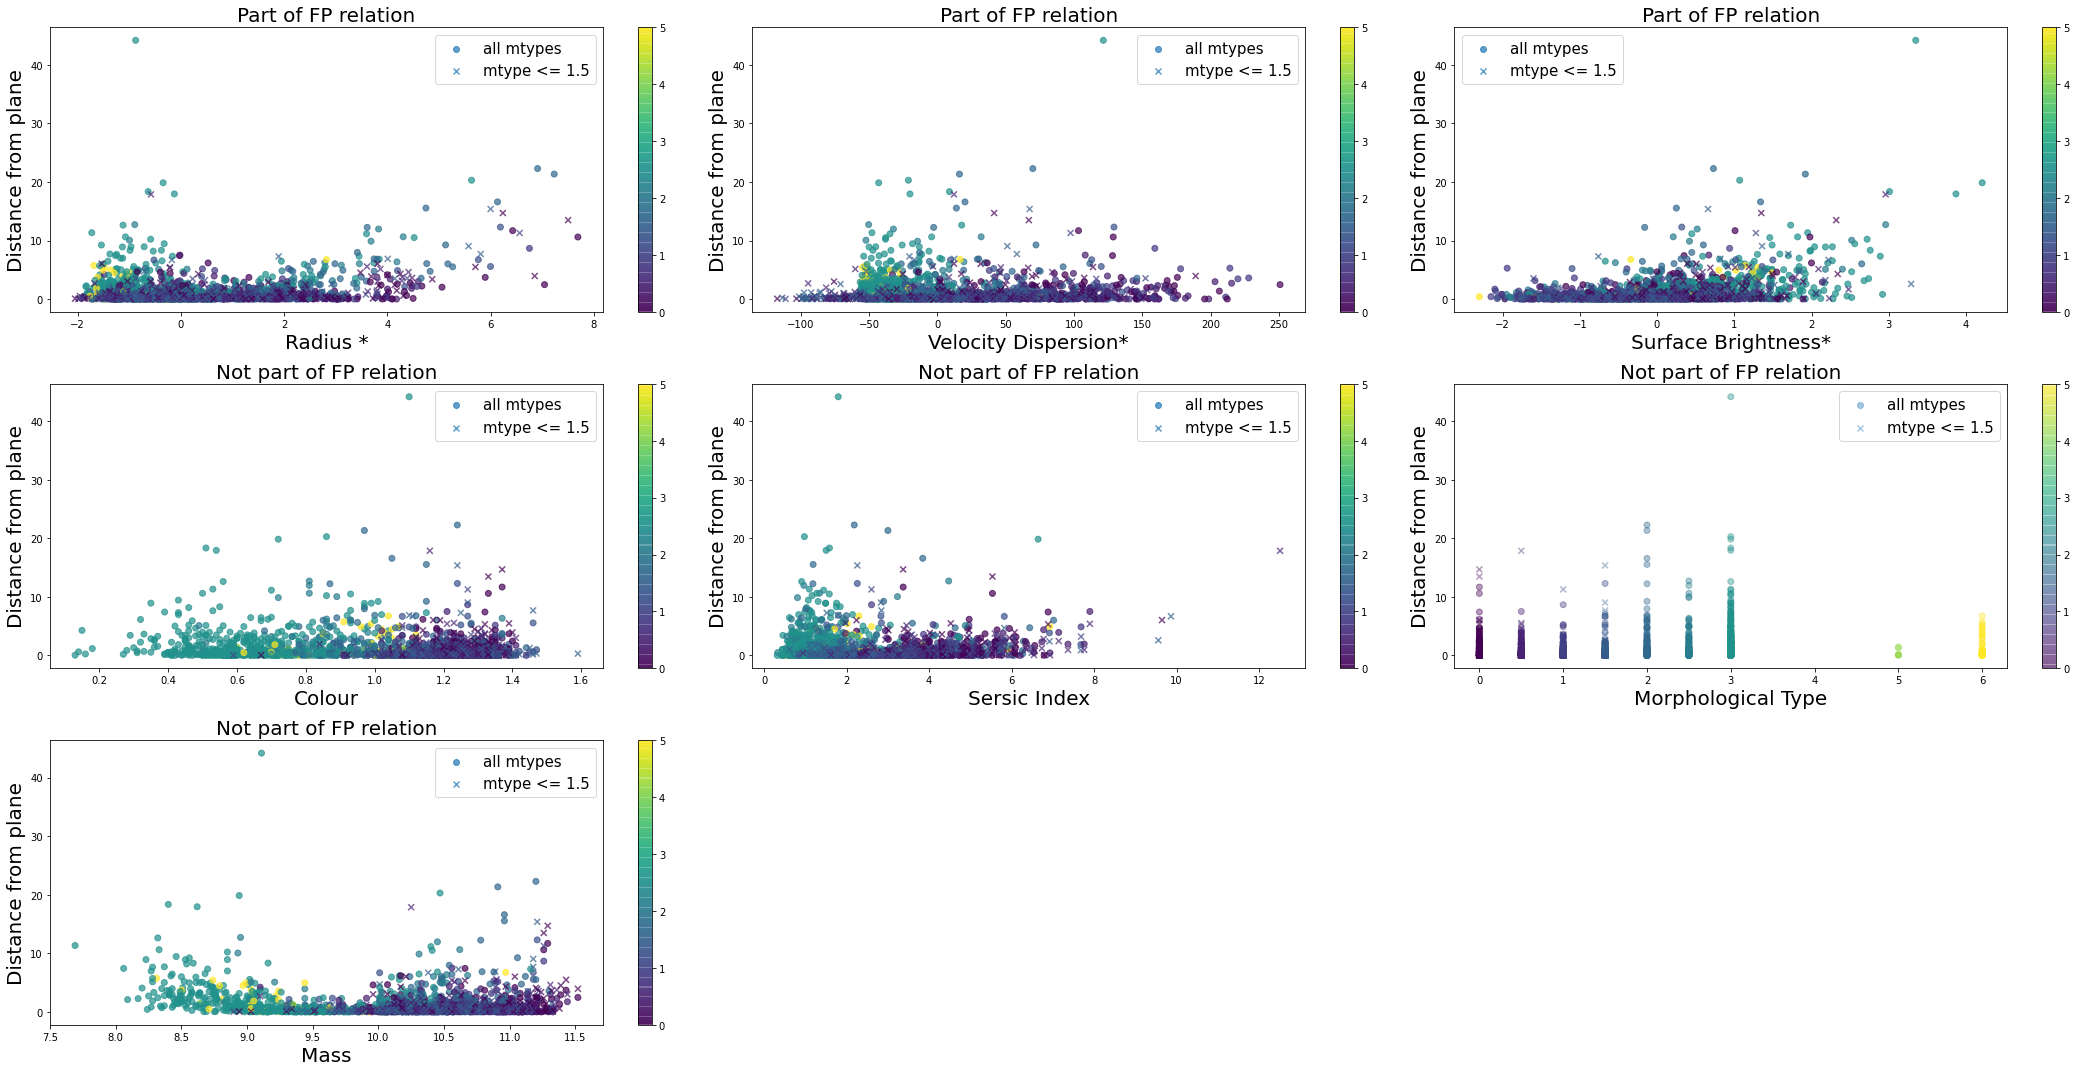

In [19]:
plt.figure(figsize=(30, 15))
c = mtype[nan_mask_all]
c_train = mtype[nan_mask]

plt.subplot(3, 3, 1)
plt.scatter(data_all[2], distances_all, c=c, alpha=0.7, label='all mtypes')
plt.scatter(data[2], distances_train, c=c_train, marker='x', alpha=0.7, label='mtype <= 1.5')
plt.xlabel('Radius *', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)
plt.legend(fontsize=15)

plt.subplot(3, 3, 2)
plt.scatter(data_all[0], distances_all, c=c, alpha=0.7, label='all mtypes')
plt.scatter(data[0], distances_train, c=c_train, marker='x', alpha=0.7, label='mtype <= 1.5')
plt.xlabel('Velocity Dispersion*', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)
plt.legend(fontsize=15)

plt.subplot(3, 3, 3)
plt.scatter(data_all[1], distances_all, c=c, alpha=0.7, label='all mtypes')
plt.scatter(data[1], distances_train, c=c_train, marker='x', alpha=0.7, label='mtype <= 1.5')
plt.xlabel('Surface Brightness*', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)
plt.legend(fontsize=15)

plt.subplot(3, 3, 4)
plt.scatter(colour[nan_mask_all], distances_all, c=c, alpha=0.7, label='all mtypes')
plt.scatter(colour[nan_mask], distances_train, c=c_train, marker='x', alpha=0.7, label='mtype <= 1.5')
plt.xlabel('Colour', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Not part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)
plt.legend(fontsize=15)

plt.subplot(3, 3, 5)
plt.scatter(sindex[nan_mask_all], distances_all, c=c, alpha=0.7, label='all mtypes')
plt.scatter(sindex[nan_mask], distances_train, c=c_train, marker='x', alpha=0.7, label='mtype <= 1.5')
plt.xlabel('Sersic Index', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Not part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)
plt.legend(fontsize=15)

plt.subplot(3, 3, 6)
plt.scatter(mtype[nan_mask_all], distances_all, c=c, alpha=0.4, label='all mtypes')
plt.scatter(mtype[nan_mask], distances_train, c=c_train, marker='x', alpha=0.4, label='mtype <= 1.5')
plt.xlabel('Morphological Type', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Not part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)
plt.legend(fontsize=15)

plt.subplot(3, 3, 7)
plt.scatter(log_mass[nan_mask_all], distances_all, c=c, alpha=0.7, label='all mtypes')
plt.scatter(log_mass[nan_mask], distances_train, c=c_train, marker='x', alpha=0.7, label='mtype <= 1.5')
plt.xlabel('Mass', fontsize=20)
plt.ylabel('Distance from plane', fontsize=20)
plt.title("Not part of FP relation", fontsize=20)
plt.colorbar()
plt.clim(0, 5)
plt.legend(fontsize=15)
 
plt.tight_layout()
plt.show()

---

# Now lets try some classification on the parameters

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, r2_score

In [21]:
cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:cyan']
names = ["Fundamental Plane", "Colour", "Radius", "Density", "Log Mass", "Mtype", "S index"]
data_raw = np.array([distances_all, colour[nan_mask_all], radius[nan_mask_all], 
                 density[nan_mask_all], log_mass[nan_mask_all], mtype[nan_mask_all], sindex[nan_mask_all]]).T

data, data_holdout = train_test_split(data_raw, test_size=0.3, random_state=0)
data = list(data.T)

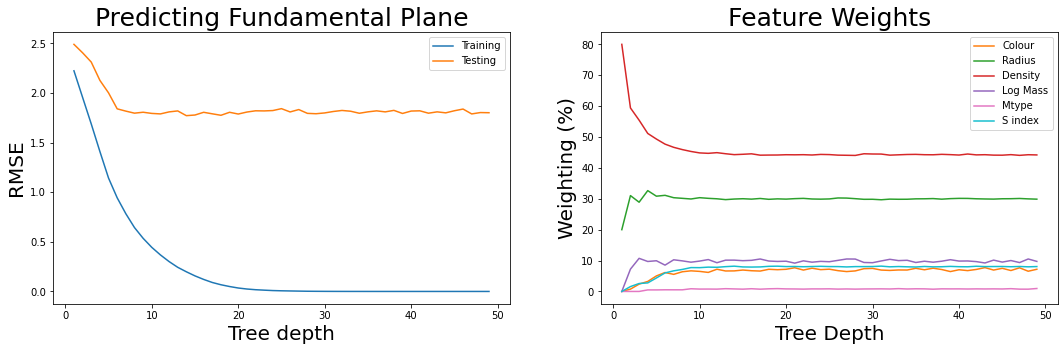

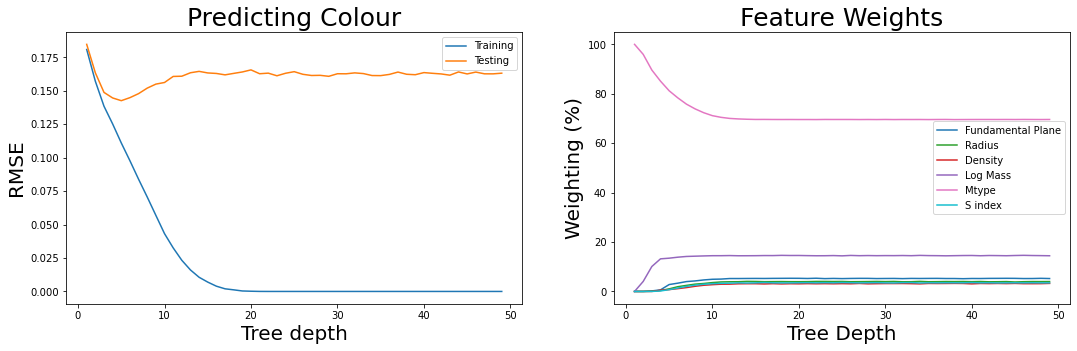

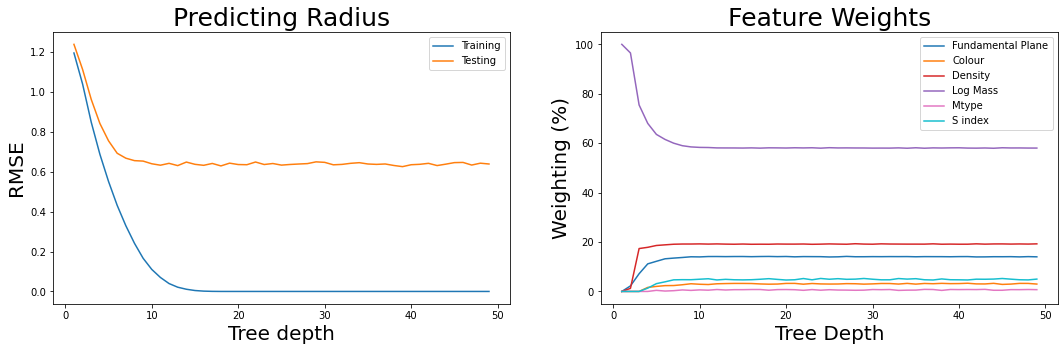

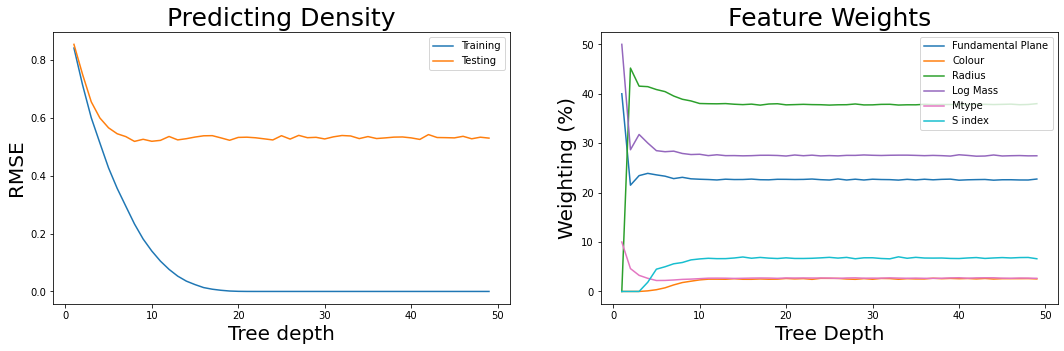

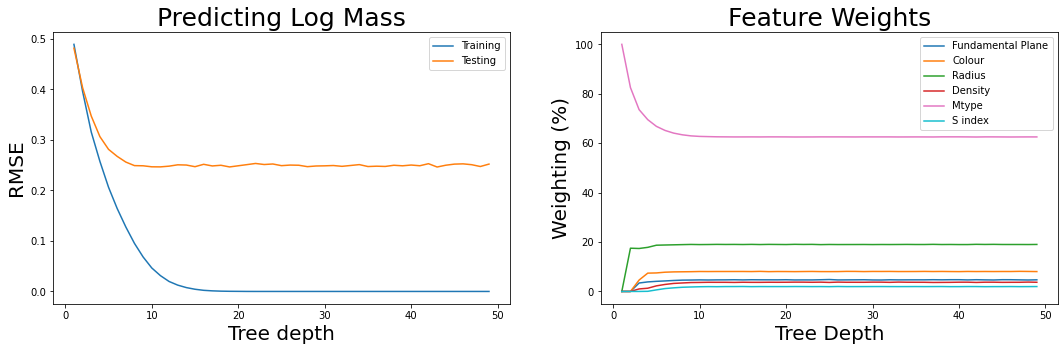

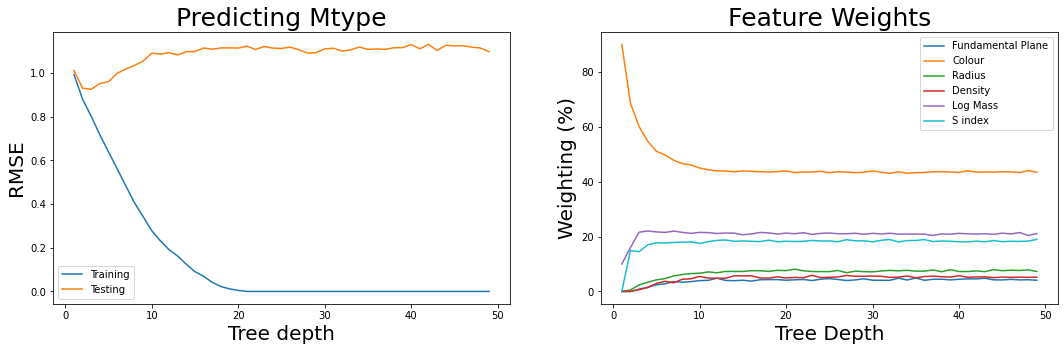

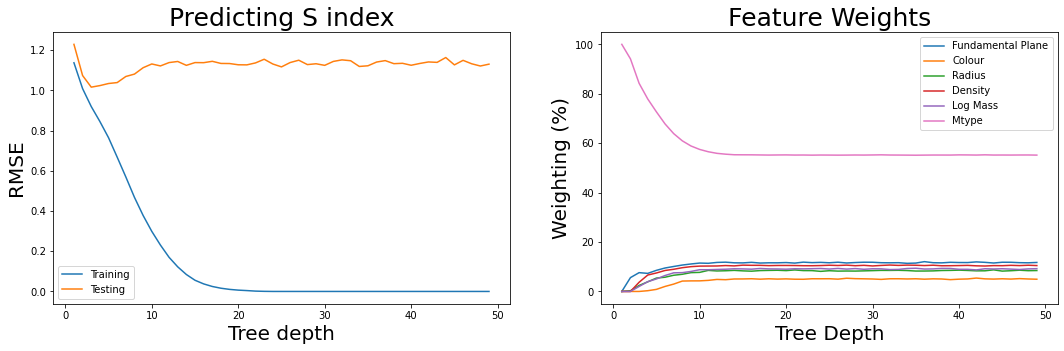

In [22]:
depths = np.arange(1, 50)
Ntest = 10
for i in range(len(data)):
    target = data[i]
    name = names[i]
    names_in = names[:i] + names[i+1:]
    data_in = np.array(data[:i] + data[i+1:]).T
    test_errs = np.zeros(depths.shape)
    train_errs = np.zeros(depths.shape)
    feature_vals = np.zeros([len(depths), len(names_in)])
    
    for j in range(len(depths)):
            for k in range(Ntest):
                X_train, X_test, Y_train, Y_test = train_test_split(data_in, target, test_size=0.25, random_state=k)
                tree = DecisionTreeRegressor(max_depth=depths[j]).fit(X_train, Y_train)
                stderr_train = np.sqrt(mean_squared_error(Y_train, tree.predict(X_train)))
                stderr_test = np.sqrt(mean_squared_error(Y_test, tree.predict(X_test)))
                test_errs[j] += stderr_test/Ntest
                train_errs[j] += stderr_train/Ntest
                feature_vals[j] += (tree.feature_importances_*100)/Ntest
    feature_vals = feature_vals.T
        
    cols_in = cols[:i] + cols[i+1:]
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 2, 1)
    plt.plot(depths, train_errs, label='Training')
    plt.plot(depths, test_errs, label='Testing')
    plt.title("Predicting {}".format(names[i]), fontsize=25)
    plt.ylabel("RMSE", fontsize=20)
    plt.xlabel("Tree depth", fontsize=20)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for j in range(len(feature_vals)):
        plt.plot(depths, feature_vals[j], label=names_in[j], c=cols_in[j])
    plt.title("Feature Weights", fontsize=25)
    plt.ylabel("Weighting (%)", fontsize=20)
    plt.xlabel("Tree Depth", fontsize=20)
    plt.legend()

    plt.show()

## From this we can see colour and S index dont do much so we can get rid of them in the classifier (and not predict mtype)

In [23]:
cols = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink']
names = ["Fundamental Plane", "Radius", "Density", "Log Mass", "Mtype"]
data_raw = np.array([distances_all, radius[nan_mask_all], density[nan_mask_all], log_mass[nan_mask_all], mtype[nan_mask_all]]).T

data, data_holdout = train_test_split(data_raw, test_size=0.3, random_state=0)
data, data_holdout = list(data.T), list(data_holdout.T)

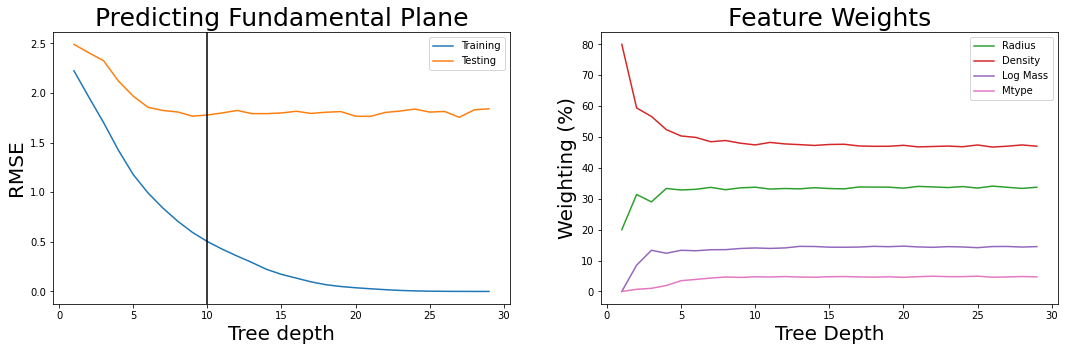

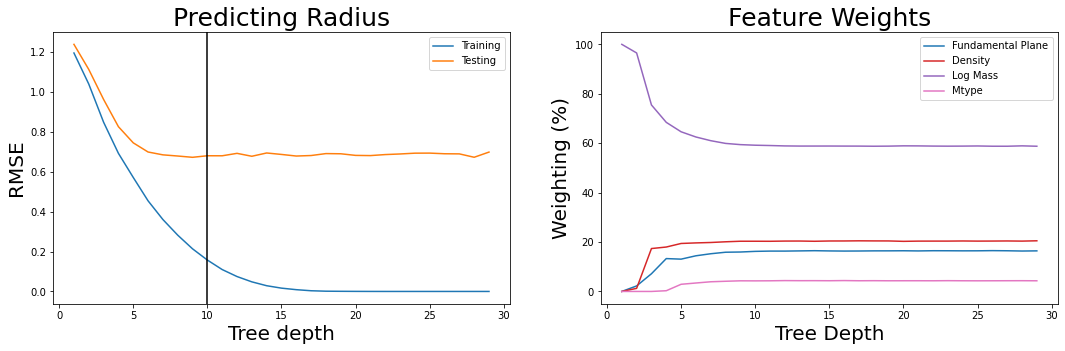

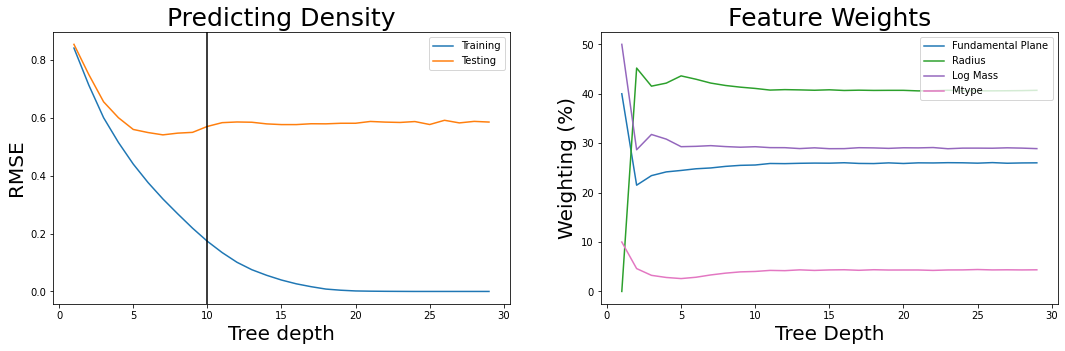

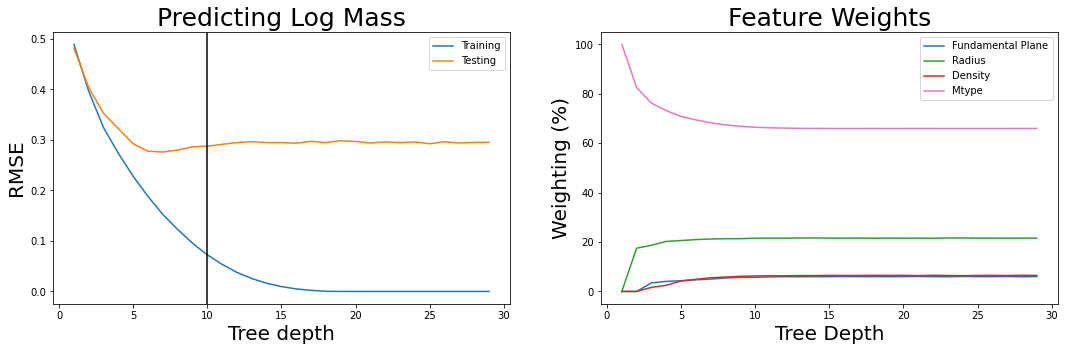

In [24]:
depths = np.arange(1, 30)
Ntest = 10
for i in range(len(data)):
    if i == 4:
        pass
    else:
        target = data[i]
        name = names[i]
        names_in = names[:i] + names[i+1:]
        data_in = np.array(data[:i] + data[i+1:]).T
        test_errs = np.zeros(depths.shape)
        train_errs = np.zeros(depths.shape)
        feature_vals = np.zeros([len(depths), len(names_in)])

        for j in range(len(depths)):
                for k in range(Ntest):
                    X_train, X_test, Y_train, Y_test = train_test_split(data_in, target, test_size=0.25, random_state=k)
                    tree = DecisionTreeRegressor(max_depth=depths[j]).fit(X_train, Y_train)
                    stderr_train = np.sqrt(mean_squared_error(Y_train, tree.predict(X_train)))
                    stderr_test = np.sqrt(mean_squared_error(Y_test, tree.predict(X_test)))
                    test_errs[j] += stderr_test/Ntest
                    train_errs[j] += stderr_train/Ntest
                    feature_vals[j] += (tree.feature_importances_*100)/Ntest
        feature_vals = feature_vals.T

        cols_in = cols[:i] + cols[i+1:]
        plt.figure(figsize=(18, 5))
        plt.subplot(1, 2, 1)
        plt.plot(depths, train_errs, label='Training')
        plt.plot(depths, test_errs, label='Testing')
        plt.axvline(10, c='k')
        plt.title("Predicting {}".format(names[i]), fontsize=25)
        plt.ylabel("RMSE", fontsize=20)
        plt.xlabel("Tree depth", fontsize=20)
        plt.legend()

        plt.subplot(1, 2, 2)
        for j in range(len(feature_vals)):
            plt.plot(depths, feature_vals[j], label=names_in[j], c=cols_in[j])
        plt.title("Feature Weights", fontsize=25)
        plt.ylabel("Weighting (%)", fontsize=20)
        plt.xlabel("Tree Depth", fontsize=20)
        plt.legend()

        plt.show()

## From this we select a tree depth of 10 as sufficient - Build the classifier (not predicting mtype)

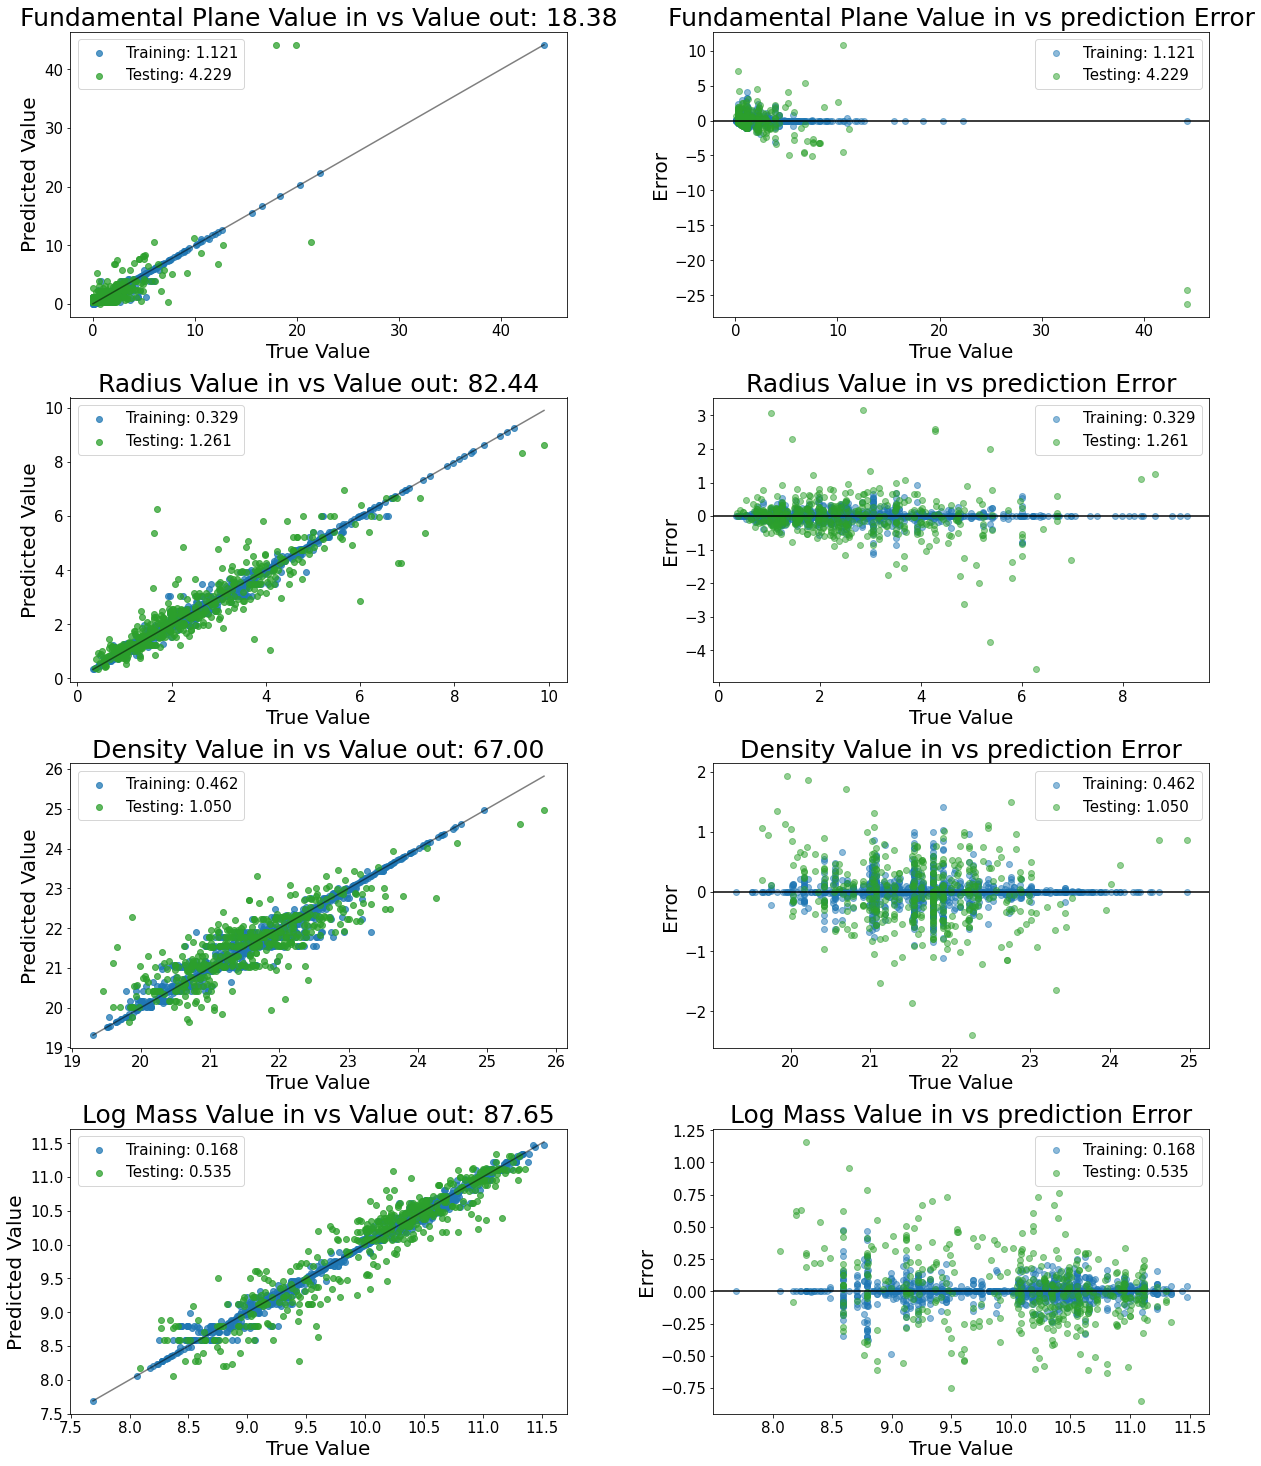

In [26]:
depth = 10
plt.figure(figsize=(18, 30))
idx = 1
for i in range(len(data)):
    if i == 4:
        pass
    else:
        name = names[i]
        names_in = names[:i] + names[i+1:]
        X_train = np.array(data[:i] + data[i+1:]).T
        Y_train = data[i]
        X_test = np.array(data_holdout[:i] + data_holdout[i+1:]).T
        Y_test = data_holdout[i]
        tree = DecisionTreeRegressor(max_depth=depth).fit(X_train, Y_train)
        stderr_train = np.sqrt(mean_squared_error(Y_train, tree.predict(X_train)))
        stderr_test = np.sqrt(mean_squared_error(Y_test, tree.predict(X_test)))
        Rsq = r2_score(Y_test, tree.predict(X_test))
        
        plt.subplot(6, 2, idx)
        plt.scatter(Y_train, tree.predict(X_train), c='tab:blue', label="Training: {:.3f}".format(2*stderr_train), alpha=0.75)
        plt.scatter(Y_test, tree.predict(X_test), c='tab:green', label="Testing: {:.3f}".format(2*stderr_test), alpha=0.75)
        plt.title("{} Value in vs Value out: {:.2f}".format(names[i], 100*Rsq), fontsize=25)
        plt.ylabel("Predicted Value", fontsize=20)
        plt.xlabel("True Value", fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        xs = np.linspace(np.min(data_raw[:, i]), np.max(data_raw[:, i]))
        plt.plot(xs, xs, c='k', alpha=0.5)
        plt.legend(fontsize=15)

        plt.subplot(6, 2, idx+1)
        plt.scatter(tree.predict(X_train), Y_train - tree.predict(X_train), c='tab:blue', label="Training: {:.3f}".format(2*stderr_train), alpha=0.5)
        plt.scatter(tree.predict(X_test), Y_test - tree.predict(X_test), c='tab:green', label="Testing: {:.3f}".format(2*stderr_test), alpha=0.5)
        plt.title("{} Value in vs prediction Error".format(names[i]), fontsize=25)
        plt.ylabel("Error", fontsize=20)
        plt.xlabel("True Value", fontsize=20)
        plt.axhline(0, c='k')
        plt.legend(fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        
        idx += 2
        
plt.tight_layout()